## KoBERT를 활용한 최신규제에 대한 **종목 영향도** 및 **핵심주제**, **피규제 종목 알림** 분석 서비스
> 팀명: 흔들리는 주가 속에서, 네 규제향이 느껴진거야   

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# colab 개발환경 세팅, 크롤링을 위한 크롬드라이버 세팅
from google.colab import drive
drive.mount('/content/gdrive/')
!pip install selenium
!pip install webdriver_manager
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin


# 한글파일, 자연어분석을 위한 패키지 설치
!pip install olefile #hwp 파싱
!pip install KoNLPy
!pip install pynori

# 자연어 분석을 위한 패키지 설치
!pip install transformers
!pip install textblob

# BertTopic 패키지 설치
!pip install bertopic
!pip install bertopic[visualization]

# 형태소 분석을 위한 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh


# 기본적 modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])
plt.rcParams['font.family'] ='Malgun Gothic'
import seaborn as sns
from IPython.display import Image
from tqdm import tqdm
import zlib
import struct
import re
import olefile
import logging
logger = logging.getLogger(__name__)


# 머신러닝 modules
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import Image
from sklearn.feature_extraction.text import TfidfVectorizer

# warnings 무시
import warnings
warnings.filterwarnings('ignore')

#pandas DataFrame 중간 행,열 생략없이 모두 출력하도록 세팅
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

os.chdir("/content/gdrive/Shareddrives/Dacon_krx/code")
os.listdir()

Mounted at /content/gdrive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 8.4 MB/s 
     |████████████████████████████████| 139 kB 46.7 MB/s 
     |████████████████████████████████| 358 kB 58.3 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 4.1 MB 45.3 MB/s 
     |████████████████████████████████| 58 kB 5.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.10 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is 

['file',
 'Mecab-ko-for-Google-Colab',
 '전체구성도.png',
 'data_preprocessing',
 'data_collect',
 'data_modeling',
 'result_plot_demo.png',
 'regulation_analysis_nlp_submit.ipynb']

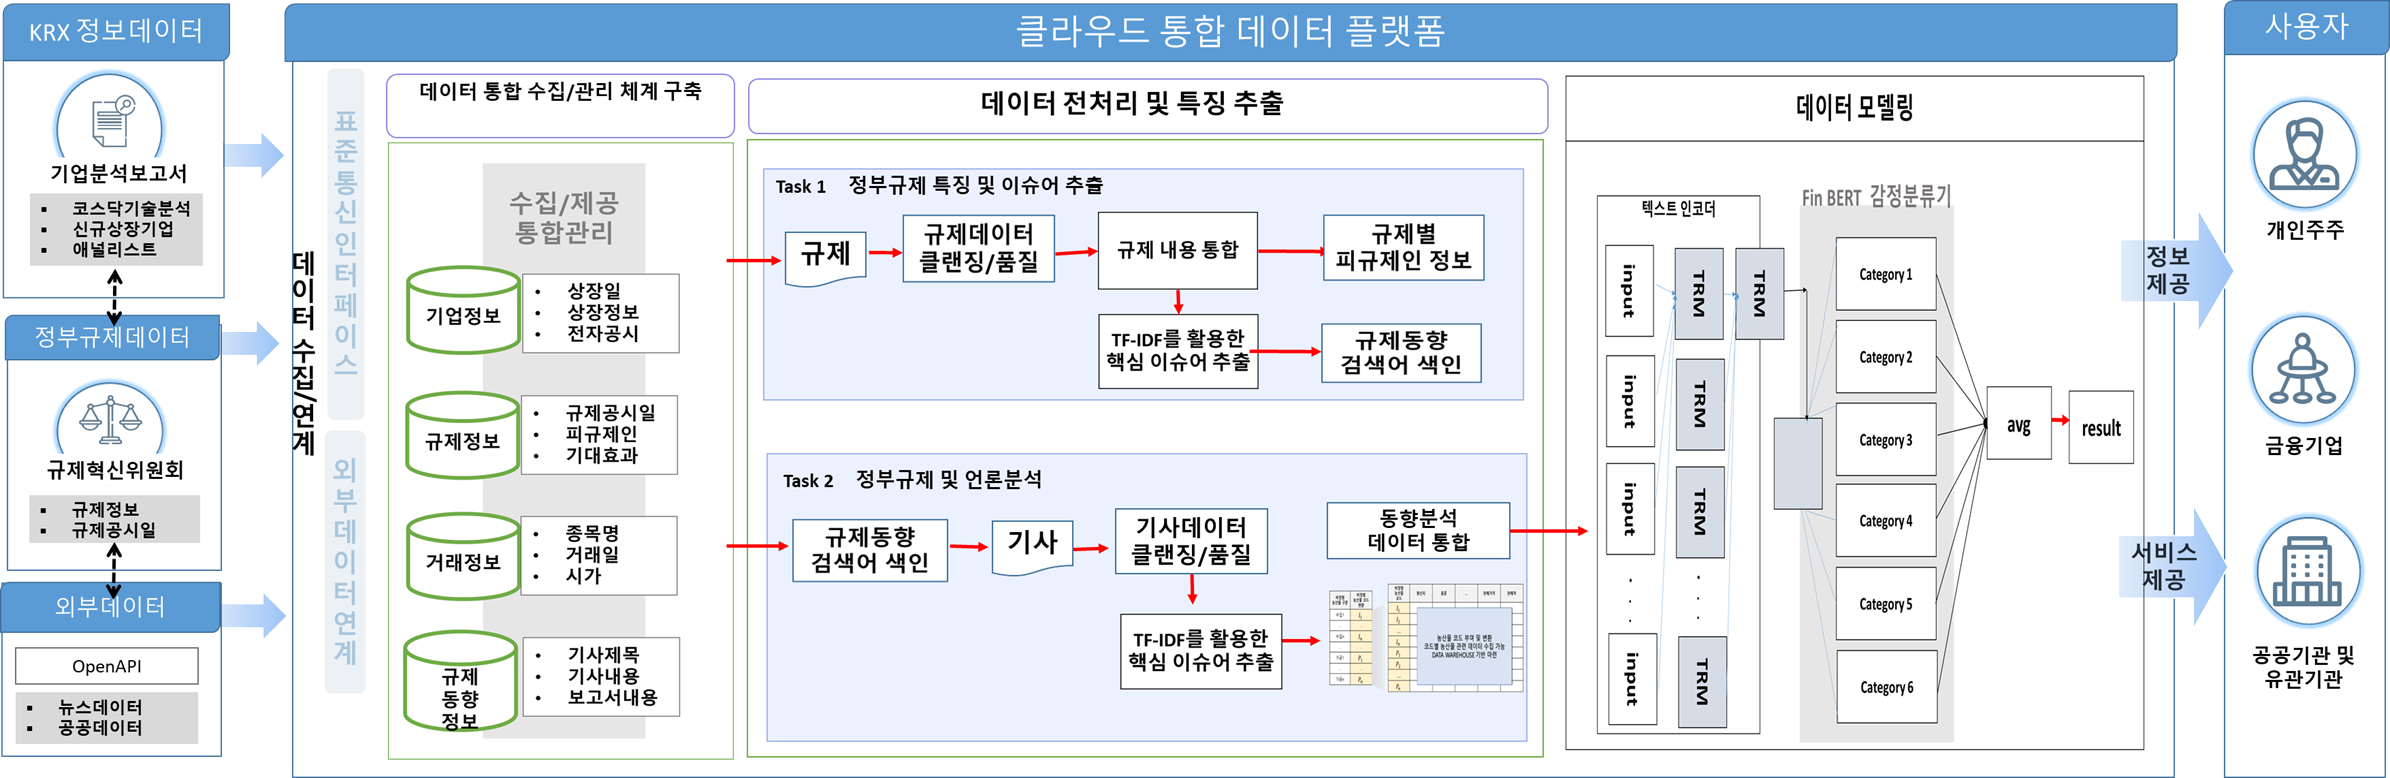

In [3]:
os.chdir("/content/gdrive/Shareddrives/Dacon_krx/code")
Image("전체구성도.png")

- 분석을 위한 전처리, 모델링, 크롤링 코드 객체 설계

In [4]:
'''
분석을 위한 전처리, 모델링, 크롤링 코드 객체 설계, custom class **
'''

# 규제정보 중 규제영향분석서 분석을 위한 클래스 객체 구현 - Import
from data_collect.parse_HWPfile import FinanaceRegulation_HWP_Parser

# 규제정보 수집을 위한 클래스 객체 구현 - Import
from data_collect.crawl_financeregulation import FinanceRegulationCrawler

# 한글 Text 전처리(Cleansing) 및 형태소 추출을 위한 클래스 객체 구현 - Import
from data_preprocessing.preprocess_text import TextCleaner, NounExtracter

# 추출된 형태소 중 TF-IDF 값을 기준으로 유의한 형태소 선별을 위한 클래스 객체 구현 - Import
from data_preprocessing.filter_noun import NounsFilter_Regulation, NounsFilter_News

# 네이버 뉴스를 크롤링하고 분석하기 위한 클래스 객체 구현 - Import
from data_collect.crawl_navernews import NaverNEWSCrawler

### 1. 최신 규제정보 크롤링하여 수집
- 규제개혁포탈에 업로드되는 규제정보 수집
- `규제영향분석서` 보고서 주요 정보 분석 및 추출
- 데모코드에서는 `page=1`만 서치하게끔 구성

In [5]:
fsc = FinanceRegulationCrawler()
res = fsc.crawl_page(folder="file")

regulation_candidate_list = list()
for r in res:
    regulation_candidate_list.append(r)

크롤링 진행 중 ... :https://www.fsc.go.kr/po040301?curPage=1
완료: 페이지1


In [6]:
regulation_list = list()

for page in regulation_candidate_list:
    for key, val in page.items():
        if val["fname"]: #규제영향 관련한 레포트가 있는 경우의 크롤링 결과를 출력
            regulation_list.append(val)
            
# 규제정보를 수집한 데이터 중 예시 출력
regulation_df = pd.DataFrame(regulation_list)
regulation_df.loc[1]

detail_url           https://www.fsc.go.kr/po040301/view?noticeId=3810&curPage=1&srchKey=&srchText=&srchBeginDt=&srchEndDt=                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

- 규제정보에서 가장 핵심적으로 중요한 필드는 다음과 같아요!
    *   date  :  예고기간을 나타내는 기간
    *   attached_contents  : 규제세부내용
- attached_contents 에 해당하는 규제세부내용은 아래의 셀과 같습니다

In [7]:
regulation_content = pd.DataFrame()
for content in regulation_df["attached_contents"] : 
  regulation_content = regulation_content.append(content)
regulation_content.loc[0]      

,1.규제사무명,2.규제조문,3.위임법령,4.유형,5.입법예고,6.추진배경및정부개입필요성,7.규제내용,8.피규제집단및이해관계자,9.도입목표및기대효과,10.비용편익분석
0,감사인 지정 방식 변경,외부감사 및 회계 등에 관한 규정 제15조 별표3 및 별표4,주식회사 등의 외부감사에 관한 법률 시행령 제16조제4항,강화,2022.07.18 2022.08.26 규제의 필요성,현재 운영 중인 감사인 지정제도가 감사품질경쟁을 저하시키는 요인으로 작용되고 있어 감사품질과 역량에 상응하는 감사인 지정이 이루어질 수 있도록 기업과 감사인간 지정 방식을 개선하여 회계투명성 제고를 추진하기 위함 회계투명성 제고를 통한 이해관계자 보호를 위해 높은 수준의 외부감사가 필요한 지정대상기업은 감사품질이 우수한 회계법인이 지정감사를 수행하도록 할 필요,기업과 감사인의 지정 군 분류 체계를 개선하고 회계법인이 상위군으로 진입하기 위해서는 강화된 품질관리수준 등을 갖출 필요,피규제집단 회계법인 유 형 인원수 또는 규모 피규제자 회계법인 21년 지정신청 회계법인 58개사,규제의 적정성,기술영향평가 경쟁영향평가 중기영향평가 해당없음 해당없음 해당없음
0,민간중금리대출 금리상한 조정,상호금융업 감독규정 제4조의6,신용협동조합법 시행령 제16조의2제1호,신설,2022.07.13 2022.07.24 규제의 필요성,최근 한국은행 기준금리 인상 등에 따라 신규 신용대출 금리가 크게 상승 금리 상승으로 중저신용자 대출금리가 민간 중금리대출 금리 상한보다 높아지는 경우 금융회사가 금리상한에 맞추어 중저신용자 대출을 민간 중금리 대출로 취급할 유인 감소 - 이에 따라 중저신용자 신용대출 금리가 더욱 크게 상승할 가능성 금리상승이 민간중금리 금리상한 요건에 반영되도록 기준을 합리화하여 금융회사에 적절한 인센티브를 부여함으로써 민간 중금리 대출 확대를 유도할 필요,비조합원 대출한도 우대가 적용되는 민간중금리 대출 적격요건 중 금리요건을 기존의 민간중금리 금리상한100분의 8.5을 기준으로 조달금리 변동 폭을 고려하여 금융위원회가 정하는 금리상한으로 변경하며 이 경우에도 금리상한 한도는 100분의 10.5로 설정,상호금융업권,중금리대출 금리요건 합리화를 통해 금융회사에게 적절한 인센티브를 부여함으로써 기존의 민간중금리 대출 금리상한을 벗어나 고금리로 대출을 이용하던 중저신용자가 보다 낮은 중금리대 대출을 이용 규제의 적정성,단위백만원 비용 편익 순비용 피규제자 피규제자 이외 정성분석 조달금리 하락시 금융회사의 인센티브 축소 조달금리를 반영하는 민간중금리 금리요건 합리화로 중금리대출 활성화 주요내용 조달금리 상승시에는 민간중금리 대출 금리상한이 상승함에 따라 금융회사에게는 인센티브가 확대되고 고금리로 대출받던 중저신용자에게는 보다 낮은 금리로 대출을 받을 수 있는 기회가 증가 조달금리 하락시에는 민간중금리 대출 금리상한이 하락함에 따라 금융회사의 인센티브는 축소되나 이는 조달비용 하락에 따른 효과로서 금융회사에게 실질적 부담이 발생한다고 보기 어려운 측면이 있으며. 중저신용자는 낮은 금리로 중금리대출 활용 가능 민간중금리 기준에 조달금리 변경을 반영함으로써 금융회사와 중저신용자에 대한 순편익 증대
0,민간중금리대출 금리상한 조정,여신전문금융업감독규정 제5조의6,여신전문금융업법시행령 제17조제2항제6호,신설,2022.07.13 2022.07.24 규제의 필요성,최근 한국은행 기준금리 인상 등에 따라 신규 신용대출 금리가 크게 상승 금리 상승으로 중저신용자 대출금리가 민간 중금리대출 금리 상한보다 높아지는 경우 금융회사가 금리상한에 맞추어 중저신용자 대출을 민간 중금리 대출로 취급할 유인 감소 - 이에 따라 중저신용자 신용대출 금리가 더욱 크게 상승할 가능성 금리상승이 민간중금리 금리상한 요건에 반영되도록 기준을 합리화하여 금융회사에 적절한 인센티브를 부여함으로써 민간 중금리 대출 확대를 유도할 필요,본업자산 대비 대출자산 비중 산정시 80로 축소 반영되는 민간중금리 대출 적격요건 중 금리요건을 기존의 민간중금리 금리상한신용카드업자는 100분의 11.0 신용카드업자가 아닌 자는 100분의 14.0을 기준으로 조달금리 변동 폭을 고려하여 금융위원회가 정하는 금리상한으로 변경하며 이 경우에도 금리상한 한도는 신용카드업자는 100분의 13.0 신용카드업자가 아닌 자는 100분의 15.5로 설정,여신전문금융업권,중금리대출 금리요건 합리화를 통해 금융회사에게 적절한 인센티브를 부여함으로써 기존의 민간중금리 대출 금리상한을 벗어나 고금리로 대출을 이용하던 중저신용자가 보다 낮은 중금리대 대출을 이용 규제의 적정성,단위백만원 비용 편익 순비용 피규제자 피규제자 이외 정성분석 조달금리 하락시 금융회사의 인센티브 축소 조달금리를 반영하는 민간중금리 금리요건 합리화로 중금리대출 활성화 주요내용 조달금리 상승시에는 민간중금리 대출 금리상한이 상승함에 따라 금융회사에게는 인센티브가 확대되고 고금리로 대출받던 중저신용자에게는 보다 낮은 금리로 대출을 받을 수 있는 기회가 증가 조달금리 하락시에는 민간중금리 대출 금리상한이 하락함에 따라 금융회사의 인센티브는 축소되나 이는 조달비용 하락에 따른 효과로서 금융회사에게 실질적 부담이 발생한다고 보기 어려운 측면이 있으며. 중저신용자는 낮은 금리로 중금리대출 활용 가능 민간중금리 기준에 조달금리 변경을 반영함으로써 금융회사와 중저신용자에 대한 순편익 증대
0,민간중금리대출 금리상한 조정,상호저축은행업감독규정 제22조의2,상호저축은행법시행령제8조의2제1호,신설,2022.07.13 2022.07.24 규제의 필요성,최근 한국은행 기준금리 인상 등에 따라 신규 신용대출 금리가 크게 상승 금리 상승으로 중저신용자 대출금리가 민간 중금리대출 금리 상한보다 높아지는 경우 금융회사가 금리상한에 맞추어 중저신용자 대출을 민간 중금리 대출로 취급할 유인 감소 - 이에 따라 중저신용자 신용대출 금리가 더욱 크게 상승할 가능성 금리상승이 민간중금리 금리상한 요건에 반영되도록 기준을 합리화하여 금융회사에 적절한 인센티브를 부여함으로써 민간 중금리 대출 확대를 유도할 필요,영업구역내 신용공여 한도에 100분의 150으로 가산되어 적용되는 민간중금리 대출 적격요건 중 금리요건을 기존의 민간중금리 금리상한100분의 16을 기준으로 조달금리 변동 폭을 고려하여 금융위원회가 정하는 금리상한으로 변경하며 이 경우에도 금리상한 한도는 100분의 17.5로 설정,상호저축은행업권,중금리대출 금리요건 합리화를 통해 금융회사에게 적절한 인센티브를 부여함으로써 기존의 민간중금리 대출 금리상한을 벗어나 고금리로 대출을 이용하던 중저신용자가 보다 낮은 중금리대 대출을 이용 규제의 적정성,단위백만원 비용 편익 순비용 피규제자 피규제자 이외 정성분석 조달금리 하락시 금융회사의 인센티브 축소 조달금리를 반영하는 민간중금리 금리요건 합리화로 중금리대출 활성화 주요내용 조달금리 상승시에는 민간중금리 대출 금리상한이 상승함에 따라 금융회사에게는 인센티브가 확대되고 고금리로 대출받던 중저신용자에게는 보다 낮은 금리로 대출을 받을 수 있는 기회가 증가 조달금리 하락시에는 민간중금리 대출 금리상한이 하락함에 따라 금융회사의 인센티브는 축소되나 이는 조달비용 하락에 따른 효과로서 금융회사에게 실질적 부담이 발생한다고 보기 어려운 측면이 있으며. 중저신용자는 낮은 금리로 중금리대출 활용 가능 민간중금리 기준에 조달금리 변경을 반영함으로써 금융회사와 중저신용자에 대한 순편익 증대


- 규제 상세 정보를 보았을 때, 규제가 적용되는 [8.피규제집단및이해관계자]은 관련 제도에대한 공시 정보 알림을 받는다면 관련된 주식과 주종에 대한 정보를 빠르게 알 수 있을 거에요!

    * 위의 데이터셋을 통해서 [규제사무명] 동일한 경우에 유형, 입법예고, 추진배경및정부개입필요성, 기대효과, 비용편익이 동일한 내용을 지님을 알 수 있어요!
    * 따라서, [규제사무명]을 기준으로 [입법예고]기간내에 [추진배경, 기대효과, 비용편익]에 대한 키워드로 관련 기사내용을 검색한다면, [피규제집단및이해관계자]들과 연관도 높은 언론 정보에 대해 긍/부/중 수치들로 관련 규제에 대한 정보 전달을 할 수 있을 거에요!
    * 최종적으로 [피규제집단및이해관계자]들에게 세부적으로 적용되는 [규제내용] 알림을 통해 정부 정책 변동에 대해 빠르게 전달 받아 대응 할 수 있는 알림서비스입니다!

In [8]:
# attached_contents을 df 형태로 변환해서 데이터셋만들기
attached_contents_df = pd.DataFrame()

for idx in range(len(regulation_df)) :
    content = regulation_df["attached_contents"].loc[idx]
    attached_contents_df = attached_contents_df.append(content, ignore_index=True)


regulation_contents = pd.concat([regulation_df, attached_contents_df], axis=1)
# 필요없는 컬럼 삭제 
del regulation_contents["detail_url"]
del regulation_contents["attached_contents"]
del regulation_contents["download_url"]

regulation_contents.rename(columns={"1.규제사무명": "규제사무명", 'cagegory3':'예고기간', "fname":"원본파일명" }, inplace = True)
regulation_contents

,subject,date,cagegory1,cagegory2,예고기간,원본파일명,규제사무명,2.규제조문,3.위임법령,4.유형,5.입법예고,6.추진배경및정부개입필요성,7.규제내용,8.피규제집단및이해관계자,9.도입목표및기대효과,10.비용편익분석
0,외부감사 및 회계 등에 관한 규정 일부개정고시(안) 규정변경예고,2022-07-18,구분규정변경예고,법률구분행정규칙,예고기간2022-07-18 ~ 2022-08-26,[3.외부감사규정규제영향분석서.hwp],감사인 지정 방식 변경,외부감사 및 회계 등에 관한 규정 제15조 별표3 및 별표4,주식회사 등의 외부감사에 관한 법률 시행령 제16조제4항,강화,2022.07.18 2022.08.26 규제의 필요성,현재 운영 중인 감사인 지정제도가 감사품질경쟁을 저하시키는 요인으로 작용되고 있어 감사품질과 역량에 상응하는 감사인 지정이 이루어질 수 있도록 기업과 감사인간 지정 방식을 개선하여 회계투명성 제고를 추진하기 위함 회계투명성 제고를 통한 이해관계자 보호를 위해 높은 수준의 외부감사가 필요한 지정대상기업은 감사품질이 우수한 회계법인이 지정감사를 수행하도록 할 필요,기업과 감사인의 지정 군 분류 체계를 개선하고 회계법인이 상위군으로 진입하기 위해서는 강화된 품질관리수준 등을 갖출 필요,피규제집단 회계법인 유 형 인원수 또는 규모 피규제자 회계법인 21년 지정신청 회계법인 58개사,규제의 적정성,기술영향평가 경쟁영향평가 중기영향평가 해당없음 해당없음 해당없음
1,상호금융업감독규정 일부개정고시(안) 규정변경예고,2022-07-13,구분규정변경예고,법률구분행정규칙,예고기간2022-07-13 ~ 2022-07-24,[3.상호금융업감독규정규제영향분석서.hwp],민간중금리대출 금리상한 조정,상호금융업 감독규정 제4조의6,신용협동조합법 시행령 제16조의2제1호,신설,2022.07.13 2022.07.24 규제의 필요성,최근 한국은행 기준금리 인상 등에 따라 신규 신용대출 금리가 크게 상승 금리 상승으로 중저신용자 대출금리가 민간 중금리대출 금리 상한보다 높아지는 경우 금융회사가 금리상한에 맞추어 중저신용자 대출을 민간 중금리 대출로 취급할 유인 감소 - 이에 따라 중저신용자 신용대출 금리가 더욱 크게 상승할 가능성 금리상승이 민간중금리 금리상한 요건에 반영되도록 기준을 합리화하여 금융회사에 적절한 인센티브를 부여함으로써 민간 중금리 대출 확대를 유도할 필요,비조합원 대출한도 우대가 적용되는 민간중금리 대출 적격요건 중 금리요건을 기존의 민간중금리 금리상한100분의 8.5을 기준으로 조달금리 변동 폭을 고려하여 금융위원회가 정하는 금리상한으로 변경하며 이 경우에도 금리상한 한도는 100분의 10.5로 설정,상호금융업권,중금리대출 금리요건 합리화를 통해 금융회사에게 적절한 인센티브를 부여함으로써 기존의 민간중금리 대출 금리상한을 벗어나 고금리로 대출을 이용하던 중저신용자가 보다 낮은 중금리대 대출을 이용 규제의 적정성,단위백만원 비용 편익 순비용 피규제자 피규제자 이외 정성분석 조달금리 하락시 금융회사의 인센티브 축소 조달금리를 반영하는 민간중금리 금리요건 합리화로 중금리대출 활성화 주요내용 조달금리 상승시에는 민간중금리 대출 금리상한이 상승함에 따라 금융회사에게는 인센티브가 확대되고 고금리로 대출받던 중저신용자에게는 보다 낮은 금리로 대출을 받을 수 있는 기회가 증가 조달금리 하락시에는 민간중금리 대출 금리상한이 하락함에 따라 금융회사의 인센티브는 축소되나 이는 조달비용 하락에 따른 효과로서 금융회사에게 실질적 부담이 발생한다고 보기 어려운 측면이 있으며. 중저신용자는 낮은 금리로 중금리대출 활용 가능 민간중금리 기준에 조달금리 변경을 반영함으로써 금융회사와 중저신용자에 대한 순편익 증대
2,여신전문금융업감독규정 일부개정고시(안) 규정변경예고,2022-07-13,구분규정변경예고,법률구분행정규칙,예고기간2022-07-13 ~ 2022-07-24,[3.여신전문금융업감독규정규제영향분석서.hwp],민간중금리대출 금리상한 조정,여신전문금융업감독규정 제5조의6,여신전문금융업법시행령 제17조제2항제6호,신설,2022.07.13 2022.07.24 규제의 필요성,최근 한국은행 기준금리 인상 등에 따라 신규 신용대출 금리가 크게 상승 금리 상승으로 중저신용자 대출금리가 민간 중금리대출 금리 상한보다 높아지는 경우 금융회사가 금리상한에 맞추어 중저신용자 대출을 민간 중금리 대출로 취급할 유인 감소 - 이에 따라 중저신용자 신용대출 금리가 더욱 크게 상승할 가능성 금리상승이 민간중금리 금리상한 요건에 반영되도록 기준을 합리화하여 금융회사에 적절한 인센티브를 부여함으로써 민간 중금리 대출 확대를 유도할 필요,본업자산 대비 대출자산 비중 산정시 80로 축소 반영되는 민간중금리 대출 적격요건 중 금리요건을 기존의 민간중금리 금리상한신용카드업자는 100분의 11.0 신용카드업자가 아닌 자는 100분의 14.0을 기준으로 조달금리 변동 폭을 고려하여 금융위원회가 정하는 금리상한으로 변경하며 이 경우에도 금리상한 한도는 신용카드업자는 100분의 13.0 신용카드업자가 아닌 자는 100분의 15.5로 설정,여신전문금융업권,중금리대출 금리요건 합리화를 통해 금융회사에게 적절한 인센티브를 부여함으로써 기존의 민간중금리 대출 금리상한을 벗어나 고금리로 대출을 이용하던 중저신용자가 보다 낮은 중금리대 대출을 이용 규제의 적정성,단위백만원 비용 편익 순비용 피규제자 피규제자 이외 정성분석 조달금리 하락시 금융회사의 인센티브 축소 조달금리를 반영하는 민간중금리 금리요건 합리화로 중금리대출 활성화 주요내용 조달금리 상승시에는 민간중금리 대출 금리상한이 상승함에 따라 금융회사에게는 인센티브가 확대되고 고금리로 대출받던 중저신용자에게는 보다 낮은 금리로 대출을 받을 수 있는 기회가 증가 조달금리 하락시에는 민간중금리 대출 금리상한이 하락함에 따라 금융회사의 인센티브는 축소되나 이는 조달비용 하락에 따른 효과로서 금융회사에게 실질적 부담이 발생한다고 보기 어려운 측면이 있으며. 중저신용자는 낮은 금리로 중금리대출 활용 가능 민간중금리 기준에 조달금리 변경을 반영함으로써 금융회사와 중저신용자에 대한 순편익 증대
3,상호저축은행업감독규정 일부개정고시(안) 규정변경예고,2022-07-13,구분규정변경예고,법률구분행정규칙,예고기간2022-07-13 ~ 2022-07-24,[3.상호저축은행업감독규정규제영향분석서.hwp],민간중금리대출 금리상한 조정,상호저축은행업감독규정 제22조의2,상호저축은행법시행령제8조의2제1호,신설,2022.07.13 2022.07.24 규제의 필요성,최근 한국은행 기준금리 인상 등에 따라 신규 신용대출 금리가 크게 상승 금리 상승으로 중저신용자 대출금리가 민간 중금리대출 금리 상한보다 높아지는 경우 금융회사가 금리상한에 맞추어 중저신용자 대출을 민간 중금리 대출로 취급할 유인 감소 - 이에 따라 중저신용자 신용대출 금리가 더욱 크게 상승할 가능성 금리상승이 민간중금리 금리상한 요건에 반영되도록 기준을 합리화하여 금융회사에 적절한 인센티브를 부여함으로써 민간 중금리 대출 확대를 유도할 필요,영업구역내 신용공여 한도에 100분의 150으로 가산되어 적용되는 민간중금리 대출 적격요건 중 금리요건을 기존의 민간중금리 금리상한100분의 16을 기준으로 조달금리 변동 폭을 고려하여 금융위원회가 정하는 금리상한으로 변경하며 이 경우에도 금리상한 한도는 100분의 17.5로 설정,상호저축은행업권,중금리대출 금리요건 합리화를 통해 금융회사에게 적절한 인센티브를 부여함으로써 기존의 민간중금리 대출 금리상한을 벗어나 고금리로 대출을 이용하던 중저신용자가 보다 낮은 중금리대 대출을 이용 규제의 적정성,단위백만원 비용 편익 순비용 피규제자 피규제자 이외 정성분석 조달금리 하락시 금융회사의 인센티브 축소 조달금리를 반영하는 민간중금리 금리요건 합리화로 중금리대출 활성화 주요내용 조달금리 상승시에는 민간중금리 대출 금리상한이 상승함에 따라 금융회사에게는 인센티브가 확대되고 고금리로 대출받던 중저신용자에게는 보다 낮은 금리로 대출을 받을 수 있는 기회가 증가 조달금리 하락시에는 민간중금리 대출 금리상한이 하락함에 따라 금융회사의 인센티브는 축소되나 이는 조달비용 하락

### 2. 최신 규제정보 키워드 생성하기

- 규제관련 뉴스정보 검색을 위한 핵심 정보키워드 추출을 위해서 데이터셋 조합은 다음과 같습니다
    *  [1.규제사무명]의 unique값 추출하기

1.   규제와 관련한 [피규제집단및이해관계자] 정리하여 추후 알림에 사용! 
2.   규제와 관련한 [검색정보] 정리하여 추후 언론 검색에 사용! 

In [9]:
regulationName_List = regulation_contents['규제사무명'].unique()

# Regulated groups and stakeholders 
regulation_content_groups = pd.DataFrame()
Regulated_groups = []

for regulationName in regulationName_List :
    # print(regulationName)
    Regulated_groups = regulation_contents[(regulation_contents['규제사무명']==f"{regulationName}")]["8.피규제집단및이해관계자"]

    regulation_Regulated = { "규제사무명" : regulationName,
                              "Regulated_groups"  : Regulated_groups.unique()}

    regulation_content_groups = regulation_content_groups.append(regulation_Regulated,ignore_index=True)

regulation_content_groups

,규제사무명,Regulated_groups
0,감사인 지정 방식 변경,[ 피규제집단 회계법인 유 형 인원수 또는 규모 피규제자 회계법인 21년 지정신청 회계법인 58개사]
1,민간중금리대출 금리상한 조정,"[상호금융업권, 여신전문금융업권, 상호저축은행업권]"


In [10]:
# 2. 중복된 규제를 제거하여 관련 규제에 대한 검색데이터 처리를 간편화함

regulation_without_duplicates = regulation_contents.drop_duplicates(subset=['규제사무명'],ignore_index=True)

print("규제 전체데이터에서 중복을 제거한 후 남은 규제데이터")
print(len(regulation_without_duplicates), "건")

규제 전체데이터에서 중복을 제거한 후 남은 규제데이터
2 건


규제명과 연관도가 높은 언론동향 및 뉴스기사를 찾기 위한 작업을 진행합니다!

1.   규제설명을 모두 합친후 명사추출하기 
2.   TFiDF를 활용하여 추출된 명사의 문서내 중요도 추출하기
3.   규제와 가장 높은 연관도를 갖는 핵심키워드 5개를 추출하기

In [11]:
# 규제와 관련한 핵심 명사들을 추출하여 해당 규제와 관련된 높은 연관도를 지닌 단어를 선정합니다!
# 이를 통해서 규제와 연관도 높은 언론동향을 파악할 수 있습니다
regulation_keyword = pd.DataFrame()

regulation_keyword["규제사무명"] =  regulation_without_duplicates["규제사무명"]
regulation_keyword["regulation_merge"] = regulation_without_duplicates["규제사무명"] +regulation_without_duplicates["2.규제조문"] + regulation_without_duplicates["6.추진배경및정부개입필요성"] + regulation_without_duplicates["7.규제내용"] + regulation_without_duplicates["9.도입목표및기대효과"]+ regulation_without_duplicates["10.비용편익분석"]
regulation_keyword["regulation_keyword"] = ""
regulation_keyword["regulation_searchword"] = ""


# 1. 규제와 관련한 명사 추출하기 
regulation_words = NounExtracter.Morph_ko_document(regulation_keyword["regulation_merge"], database = "hannanum")
# print(regulation_word)

# 2. 규제별로 명사개수 확인하기
nomarl_freq = pd.DataFrame()

num = 0
for regulation_word in regulation_words: 
    regulation_wordFreq = NounsFilter_Regulation.get_frequency(regulation_word)
    regulation_wordFreq["규제명"] = num 
    num += 1
    nomarl_freq = nomarl_freq.append(regulation_wordFreq)

# 3.  TFIDF로 유사도 계산하여 의미있는 명사만 남기기!
tfidf_values =  NounsFilter_Regulation.Tfidf(regulation_words)
tfidf_result = NounsFilter_Regulation.tfidf_result(nomarl_freq, tfidf_values )

tfidf_result = tfidf_result.drop(tfidf_result[(tfidf_result["NMR"]==1)].index).dropna()
# print(tfidf_result)


# 4. 각각의 규제에 영향도가 높은 단어를 매칭하여 뉴스검색을 위한 규제데이터셋 생성하기
print("각각의 규제에 영향도가 높은 단어 매칭")

regulation_keyword["regulation_keyword"][0] = list(tfidf_result[(tfidf_result["규제명"]==0)]["word"])
regulation_keyword["regulation_keyword"][1] = list(tfidf_result[(tfidf_result["규제명"]==1)]["word"])

regulation_keyword

각각의 규제에 영향도가 높은 단어 매칭


,규제사무명,regulation_merge,regulation_keyword,regulation_searchword
0,감사인 지정 방식 변경,감사인 지정 방식 변경외부감사 및 회계 등에 관한 규정 제15조 별표3 및 별표4 현재 운영 중인 감사인 지정제도가 감사품질경쟁을 저하시키는 요인으로 작용되고 있어 감사품질과 역량에 상응하는 감사인 지정이 이루어질 수 있도록 기업과 감사인간 지정 방식을 개선하여 회계투명성 제고를 추진하기 위함 회계투명성 제고를 통한 이해관계자 보호를 위해 높은 수준의 외부감사가 필요한 지정대상기업은 감사품질이 우수한 회계법인이 지정감사를 수행하도록 할 필요 기업과 감사인의 지정 군 분류 체계를 개선하고 회계법인이 상위군으로 진입하기 위해서는 강화된 품질관리수준 등을 갖출 필요규제의 적정성기술영향평가 경쟁영향평가 중기영향평가 해당없음 해당없음 해당없음,"[지정, 해당, 회계투명성, 기업, 별표, 방식, 제고, 감사인, 감사, 회계법인, 감사품질, 개선]",
1,민간중금리대출 금리상한 조정,민간중금리대출 금리상한 조정상호금융업 감독규정 제4조의6 최근 한국은행 기준금리 인상 등에 따라 신규 신용대출 금리가 크게 상승 금리 상승으로 중저신용자 대출금리가 민간 중금리대출 금리 상한보다 높아지는 경우 금융회사가 금리상한에 맞추어 중저신용자 대출을 민간 중금리 대출로 취급할 유인 감소 - 이에 따라 중저신용자 신용대출 금리가 더욱 크게 상승할 가능성 금리상승이 민간중금리 금리상한 요건에 반영되도록 기준을 합리화하여 금융회사에 적절한 인센티브를 부여함으로써 민간 중금리 대출 확대를 유도할 필요 비조합원 대출한도 우대가 적용되는 민간중금리 대출 적격요건 중 금리요건을 기존의 민간중금리 금리상한100분의 8.5을 기준으로 조달금리 변동 폭을 고려하여 금융위원회가 정하는 금리상한으로 변경하며 이 경우에도 금리상한 한도는 100분의 10.5로 설정 중금리대출 금리요건 합리화를 통해 금융회사에게 적절한 인센티브를 부여함으로써 기존의 민간중금리 대출 금리상한을 벗어나 고금리로 대출을 이용하던 중저신용자가 보다 낮은 중금리대 대출을 이용 규제의 적정성 단위백만원 비용 편익 순비용 피규제자 피규제자 이외 정성분석 조달금리 하락시 금융회사의 인센티브 축소 조달금리를 반영하는 민간중금리 금리요건 합리화로 중금리대출 활성화 주요내용 조달금리 상승시에는 민간중금리 대출 금리상한이 상승함에 따라 금융회사에게는 인센티브가 확대되고 고금리로 대출받던 중저신용자에게는 보다 낮은 금리로 대출을 받을 수 있는 기회가 증가 조달금리 하락시에는 민간중금리 대출 금리상한이 하락함에 따라 금융회사의 인센티브는 축소되나 이는 조달비용 하락에 따른 효과로서 금융회사에게 실질적 부담이 발생한다고 보기 어려운 측면이 있으며. 중저신용자는 낮은 금리로 중금리대출 활용 가능 민간중금리 기준에 조달금리 변경을 반영함으로써 금융회사와 중저신용자에 대한 순편익 증대,"[대출, 금리상한, 민간중금리, 금융회사, 금리, 중저신용자, 조달금리, 인센티브, 상승, 중금리대출]",


### 3. 규제정보 키워드를 활용하여 최신 뉴스 크롤링하여 수집
- 네이버 검색을 통한 뉴스 정보 크롤링
- 주요 정보 파싱하여 정보 추출, 정리(pd.DataFrame)
- 데모 시연을 위한 예제 선정 pick index as '1'

In [12]:
selected_regulation = regulation_keyword["규제사무명"].loc[1] # 데모 시연을 위한 예제 선정 pick index '1'
print(f"데모 시연을 위해 선정한 CASE: {selected_regulation}")

데모 시연을 위해 선정한 CASE: 민간중금리대출 금리상한 조정


In [13]:
keywords = regulation_keyword["regulation_keyword"].loc[1]
print(f"규제관련 뉴스 검색 키워드: {keywords}")

규제관련 뉴스 검색 키워드: ['대출', '금리상한', '민간중금리', '금융회사', '금리', '중저신용자', '조달금리', '인센티브', '상승', '중금리대출']


In [14]:
keyword = '민간중금리대출 금리상한 조정'
news = NaverNEWSCrawler(keyword=keyword, end_pg=4)
news.news_df

https://n.news.naver.com/mnews/article/001/0013316949?sid=101
https://n.news.naver.com/mnews/article/374/0000294986?sid=101
https://n.news.naver.com/mnews/article/014/0004859496?sid=101
https://n.news.naver.com/mnews/article/032/0003156340?sid=101
https://n.news.naver.com/mnews/article/081/0003283600?sid=101
https://n.news.naver.com/mnews/article/009/0004988140?sid=101
https://n.news.naver.com/mnews/article/374/0000294986?sid=101
https://n.news.naver.com/mnews/article/014/0004859496?sid=101
https://n.news.naver.com/mnews/article/001/0013276638?sid=101
https://n.news.naver.com/mnews/article/081/0003283600?sid=101
https://n.news.naver.com/mnews/article/009/0004988140?sid=101
https://n.news.naver.com/mnews/article/374/0000294986?sid=101
https://n.news.naver.com/mnews/article/014/0004859496?sid=101
https://n.news.naver.com/mnews/article/001/0013276638?sid=101
https://n.news.naver.com/mnews/article/081/0003283600?sid=101
https://n.news.naver.com/mnews/article/009/0004988140?sid=101
https://

,date,title,content,link
0,None,[대출금리 7% 땐 190만명 '최저 생계비 빼면' 원리금 못 갚는다],"[\n건보료만 내도 원리금 못 갚는 차주 120만명금융당국, 2금융권 중금리대출 상한선 올려 고금리 중·저신용자 이용 유도 \n\n\n\n서울시내 한 시중은행 대출 창구[연합뉴스 자료 사진] 2022.7.13 hama@yna.co.kr (서울=연합뉴스) 심재훈 이지헌 오주현 기자 = 가계 대출 평균 금리가 7% 수준에 이를 경우 소득에서 최저 생계비를 빼면 대출 원리금도 못 갚는 사람이 190만명에 달하는 것으로 파악됐다. 특히, 금리가 높은 대부업, 저축은행 등 2금융권과 자영업자의 다중 채무가 급증하는 것으로 파악돼 금융당국은 2금융권의 민간 중금리대출 상한선을 재조정하는 등 중·저신용자 보호에 적극적으로 나설 방침이다. 18일 금융권 등에 따르면 금융감독원이 최근 금리 급등기를 맞아 금리 상승이 가계 대출 차주의 상환 능력에 미치는 영향을 분석했더니 이런 결과가 나왔다.\n\n\n\n[그래픽] 금리 3%p 상승 시 가계대출자에 미치는 영향(서울=연합뉴스) 원형민 기자 = circlemin@yna.co.kr 페이스북 tuney.kr/LeYN1 트위터 @yonhap_graphics 올해 3월 말 현재 전체 금융권의 가계 대출은 1천616조2천억원으로, 평균 금리(3.96%)가 3%포인트 상승하면 대출자 1천646만명 중 총부채원리금상환비율(DSR)이 70%를 넘는 경우가 190만명에 달하는 것으로 분석됐다. 이는 기존 140만명에서 50만명이 늘어난 것이며 이들의 부채 금액은 357조5천억원에서 480조4천억원으로 122조9천억원이나 증가하게 된다.\n\n\n\n금리인상에 '영끌족' 이자부담 어쩌나(서울=연합뉴스) 신준희 기자 = 13일 서울시내 한 시중은행 대출 창구. 한국은행 금통위는 이날 기준금리를 한꺼번에 0.50%포인트 올렸다. 이에 따라 대출금리가 기준금리 인상 폭만큼만 올라도 가계대출자의 이자 부담은 24조원 가까이 불어날 것으로 추정된다. 2022.7.13 hama@yna.co.kr DSR이란 1년 동안 갚아야 하는 대출이자와 대출 원금이 소득과 비교해 얼마나 되는지를 계산한 수치다. DSR이 70%를 초과하는 경우 일반적으로 소득에서 최저 생계비를 제외했을 때 원리금을 감당하지 못하는 차주로 분류된다. 소득에서 소득세와 건강보험료 등만 차감해도 원리금을 못 갚는 대출자를 의미하는 DSR 90% 초과 차주는 평균 금리(3.96%)가 3%포인트 상승하면 90만명에서 120만명으로 30만명 증가하는 것으로 파악됐다. 이들의 부채 금액은 254조원에서 336조원으로 늘어나게 된다. 이럴 경우 DSR 90% 초과 차주 비중은 2금융권이 8.4%(62만명)에서 10.3%(76만명), 자영업자는 10.2%(21만9천명)에서 13%(28만명)로 각각 늘게 된다. 다중 채무자 중 DSR 90% 초과 차주 비중은 8.7%(33만2천명)에서 12%(45만6천명)로 급증하게 된다. 금융시장에서는 미국 연방준비제도(Fed·연준)가 강도 높은 긴축을 이어가고 있고 최근 빅스텝(한번에 기준금리 0.50%포인트 인상)을 단행한 한국은행도 계속해서 기준금리를 올릴 것으로 예상돼 시장 금리 상승도 가속할 것으로 예측하고 있다. 금융위원회와 금감원 등 금융 당국은 이런 금리 상승기를 맞아 2금융권에서 대출이 많은 자영업자의 연착륙 유도를 적극적으로 추진할 방침이다. 금융당국은 중·저신용자에 대한 자금 공급을 원활히 하기 위해 2016년부터 중금리 대출 제도를 운용하고 있다. 중금리 대출 공급액은 2016년 1조3천억원에서 지난해 21조5천억원으로 급증했다. \n\n\n\n서울시내 한 시중은행 대출 창구[연합뉴스 자료사진] 2022.7.13 hama@yna.co.kr이 가운데 민간 중금리 대출은 신용 하위 50%인 개인 대출자를 위한 제도로, 업권별 금리 상한 요건을 충족하는 비보증부 신용대출에 대해 인센티브를 부여하는 방식으로 운영하고 있다. 금융위는 최근 민간 중금리 대출의 금리 상한 기준을 합리화하는 내용의 상호금융업·저축은행·여신전문금융업 감독규정 일부 개정 고시의 규정 변경을 예고했다. 이는 최근 금리가 급등하는 가운데 고금리로 대출을 이용하던 중·저신용자가 보다 낮은 중금리대 대출을 이용할 수 있도록 민간 중금리 금리상한 기준을 합리화하기 위한 조치다. 이에 따라 상호금융의 경우 민간 중금리 대출의 금리 상한을 8.5%에서 10.5%로 상향 조정하기로 했다. 여신전문금융업은 신용카드업의 경우 민간 중금리 대출의 금리 상한을 11%에서 13%, 신용카드 외 사업자는 14%에서 15.5%로 설정할 예정이다. 저축은행은 16%에서 17.5%로 올릴 방침이다. 금융당국 관계자는 ""최근 기준금리 인상 등에 따라 신규 신용대출 금리가 크게 올랐다""면서 ""중·저신용자의 기존 대출 금리가 민간 중금리 대출 금리 상한보다 높아지는 경우 금융사는 중·저신용자 대출을 민간 중금리 대출로 취급할 이유가 줄어들게 된다""고 말했다. 그는 ""이렇게 되면 중·저신용자 신용대출 금리가 급등할 가능성이 있다""면서 ""이번 조치는 최근의 금리 상승분을 민간 중금리 대출의 금리 상한 요건에 반영해 금융사에 적절한 인센티브를 부여함으로써 민간 중금리 대출 확대를 유도하기 위한 것""이라고 덧붙였다. president21@yna.co.kr pan@yna.co.kr viva5@yna.co.kr\n]",https://n.news.naver.com/mnews/article/001/0013316949?sid=101
1,None,[대출금리 7% 땐 190만명 원리금 못 갚아],"[\n\t\t\t[앵커] 이렇게 다양한 대응 방안이 시도되고 있지만, 금리 인상 자체를 막을 순 없겠죠.지금처럼 금리가 올라서 가계대출의 평균금리가 7%에 도달하면, 190만명에 달하는 사람이 최저 생계비를 빼면 원리금도 못 갚는 것으로 파악됐습니다.엄하은 기자, 정확히 어떤 통계가 나온 건가요?[기자]총부채원리금상환비율인 DSR이 70%를 초과하면, 일반적으로 소득에서 최저 생계비를 뺐을 때 원리금을 감당하지 못하는 차주로 분류됩니다.금융권에 따르면 올해 3월 말 기준 전체 금융권 가계 대출은 1616조 2천억원인데요.3.96%인 평균 금리가 3%p 상승하면 대출자 1646만명 중 DSR이 70%를 초과하는 경우가 190만명에 달하는 것으로 분석됐습니다.기존 140만명에서 50만명이 늘어난 것인데, 이들의 부채 금액은 122조 9천억원 늘어, 480조 4천억원으로 증가하게 됩니다.소득에서 소득세와 건강보험료 등만 차감해도 원리금을 못 갚는 대출자를 의미하는 DSR 90% 초과 차주들도 30만명 증가하는 것으로 파악됐는데요.특히, 금리가 높은 대부업, 저축은행 등 2금융권과 자영업자의 다중 채무가 급증하는 것으로 나타났습니다.[앵커]문제는 앞으로 금리가 더 오른다는 거잖아요?[기자]미국 연방준비제도가 강도 높은 긴축을 이어가고 있고, 여기에 맞춰 한국은행도 기준금리를 올릴 거라 시중금리 상승은 더 가팔라질 것으로 보입니다.금융당국은 2금융권에서 대출이 많은 자영업자 등의 연착륙을 유도할 방침입니다.중·저신용자가 보다 낮은 중금리대 대출을 이용할 수 있도록 민간 중금리 금리상한 기준을 합리화하기 위한 조치에 나섰는데요.이에 따라 상호금융은 민간 중금리 대출의 금리 상한을 8.5%에서 10.5%로 상향 조정하기로 했습니다.SBS Biz 엄하은입니다. \n\t\t]",https://n.news.naver.com/mnews/article/374/0000294986?sid=101
2,None,[금리상승에 중금리 상한 합리화..중금리 대출 확대 유도],"[\n\t\t\t [파이낸셜뉴스] \n\n\n\n2022년 하반기 민간중금리 대출 금리상한 요건 사진=뉴시스 금리가 급격히 오르자 금융당국이 금융권 중금리 대출 금리 상한 요건 산정 방식을 변경하기로 했다. 금리 상승이 중금리 금리상한 요건에 반영되도록 기준을 합리화해 중금리 대출 확대를 유도하겠다는 것이다. 29일 금융위원회는 '민간중금리 대출 금리요건 개선방안'을 통해 매반기 조달금리 변동 폭을 근거로 민간중금리대출 금리 

### 4. 규제정보 뉴스데이터 전처리
- 파싱 결과 얻어진 규제정보와 뉴스데이터 전처리(클린 텍스트)
- 형태소 추출(예선: 한나눔 사전 사용하여 한국어 형태소 분석 추출)
- Filtering Noun: Using Frequent Value and TF-IDF sparse matrix 

In [15]:
nouns_candidate_per_news = NounExtracter.Morph_ko_document(news.news_df["content"], database="hannanum")
nouns_per_news = list()
for nouns in nouns_candidate_per_news:
    nouns_per_news.append(nouns)

nouns_df = pd.DataFrame({"nouns": nouns_per_news})

- 규제에 대한 뉴스 데이터: `X_news_contents`

In [16]:
X_news_contents = pd.concat([news.news_df, nouns_df], axis=1)

best_nouns= list()
for idx, series in X_news_contents["content"].iteritems():
    filter = NounsFilter_News(pd.Series(series))
    best_nouns.append(filter.pick_the_best_K_nouns(K=10).values)
    
X_news_contents["best_nouns"] = best_nouns
X_news_contents

,date,title,content,link,nouns,best_nouns
0,None,[대출금리 7% 땐 190만명 '최저 생계비 빼면' 원리금 못 갚는다],"[\n건보료만 내도 원리금 못 갚는 차주 120만명금융당국, 2금융권 중금리대출 상한선 올려 고금리 중·저신용자 이용 유도 \n\n\n\n서울시내 한 시중은행 대출 창구[연합뉴스 자료 사진] 2022.7.13 hama@yna.co.kr (서울=연합뉴스) 심재훈 이지헌 오주현 기자 = 가계 대출 평균 금리가 7% 수준에 이를 경우 소득에서 최저 생계비를 빼면 대출 원리금도 못 갚는 사람이 190만명에 달하는 것으로 파악됐다. 특히, 금리가 높은 대부업, 저축은행 등 2금융권과 자영업자의 다중 채무가 급증하는 것으로 파악돼 금융당국은 2금융권의 민간 중금리대출 상한선을 재조정하는 등 중·저신용자 보호에 적극적으로 나설 방침이다. 18일 금융권 등에 따르면 금융감독원이 최근 금리 급등기를 맞아 금리 상승이 가계 대출 차주의 상환 능력에 미치는 영향을 분석했더니 이런 결과가 나왔다.\n\n\n\n[그래픽] 금리 3%p 상승 시 가계대출자에 미치는 영향(서울=연합뉴스) 원형민 기자 = circlemin@yna.co.kr 페이스북 tuney.kr/LeYN1 트위터 @yonhap_graphics 올해 3월 말 현재 전체 금융권의 가계 대출은 1천616조2천억원으로, 평균 금리(3.96%)가 3%포인트 상승하면 대출자 1천646만명 중 총부채원리금상환비율(DSR)이 70%를 넘는 경우가 190만명에 달하는 것으로 분석됐다. 이는 기존 140만명에서 50만명이 늘어난 것이며 이들의 부채 금액은 357조5천억원에서 480조4천억원으로 122조9천억원이나 증가하게 된다.\n\n\n\n금리인상에 '영끌족' 이자부담 어쩌나(서울=연합뉴스) 신준희 기자 = 13일 서울시내 한 시중은행 대출 창구. 한국은행 금통위는 이날 기준금리를 한꺼번에 0.50%포인트 올렸다. 이에 따라 대출금리가 기준금리 인상 폭만큼만 올라도 가계대출자의 이자 부담은 24조원 가까이 불어날 것으로 추정된다. 2022.7.13 hama@yna.co.kr DSR이란 1년 동안 갚아야 하는 대출이자와 대출 원금이 소득과 비교해 얼마나 되는지를 계산한 수치다. DSR이 70%를 초과하는 경우 일반적으로 소득에서 최저 생계비를 제외했을 때 원리금을 감당하지 못하는 차주로 분류된다. 소득에서 소득세와 건강보험료 등만 차감해도 원리금을 못 갚는 대출자를 의미하는 DSR 90% 초과 차주는 평균 금리(3.96%)가 3%포인트 상승하면 90만명에서 120만명으로 30만명 증가하는 것으로 파악됐다. 이들의 부채 금액은 254조원에서 336조원으로 늘어나게 된다. 이럴 경우 DSR 90% 초과 차주 비중은 2금융권이 8.4%(62만명)에서 10.3%(76만명), 자영업자는 10.2%(21만9천명)에서 13%(28만명)로 각각 늘게 된다. 다중 채무자 중 DSR 90% 초과 차주 비중은 8.7%(33만2천명)에서 12%(45만6천명)로 급증하게 된다. 금융시장에서는 미국 연방준비제도(Fed·연준)가 강도 높은 긴축을 이어가고 있고 최근 빅스텝(한번에 기준금리 0.50%포인트 인상)을 단행한 한국은행도 계속해서 기준금리를 올릴 것으로 예상돼 시장 금리 상승도 가속할 것으로 예측하고 있다. 금융위원회와 금감원 등 금융 당국은 이런 금리 상승기를 맞아 2금융권에서 대출이 많은 자영업자의 연착륙 유도를 적극적으로 추진할 방침이다. 금융당국은 중·저신용자에 대한 자금 공급을 원활히 하기 위해 2016년부터 중금리 대출 제도를 운용하고 있다. 중금리 대출 공급액은 2016년 1조3천억원에서 지난해 21조5천억원으로 급증했다. \n\n\n\n서울시내 한 시중은행 대출 창구[연합뉴스 자료사진] 2022.7.13 hama@yna.co.kr이 가운데 민간 중금리 대출은 신용 하위 50%인 개인 대출자를 위한 제도로, 업권별 금리 상한 요건을 충족하는 비보증부 신용대출에 대해 인센티브를 부여하는 방식으로 운영하고 있다. 금융위는 최근 민간 중금리 대출의 금리 상한 기준을 합리화하는 내용의 상호금융업·저축은행·여신전문금융업 감독규정 일부 개정 고시의 규정 변경을 예고했다. 이는 최근 금리가 급등하는 가운데 고금리로 대출을 이용하던 중·저신용자가 보다 낮은 중금리대 대출을 이용할 수 있도록 민간 중금리 금리상한 기준을 합리화하기 위한 조치다. 이에 따라 상호금융의 경우 민간 중금리 대출의 금리 상한을 8.5%에서 10.5%로 상향 조정하기로 했다. 여신전문금융업은 신용카드업의 경우 민간 중금리 대출의 금리 상한을 11%에서 13%, 신용카드 외 사업자는 14%에서 15.5%로 설정할 예정이다. 저축은행은 16%에서 17.5%로 올릴 방침이다. 금융당국 관계자는 ""최근 기준금리 인상 등에 따라 신규 신용대출 금리가 크게 올랐다""면서 ""중·저신용자의 기존 대출 금리가 민간 중금리 대출 금리 상한보다 높아지는 경우 금융사는 중·저신용자 대출을 민간 중금리 대출로 취급할 이유가 줄어들게 된다""고 말했다. 그는 ""이렇게 되면 중·저신용자 신용대출 금리가 급등할 가능성이 있다""면서 ""이번 조치는 최근의 금리 상승분을 민간 중금리 대출의 금리 상한 요건에 반영해 금융사에 적절한 인센티브를 부여함으로써 민간 중금리 대출 확대를 유도하기 위한 것""이라고 덧붙였다. president21@yna.co.kr pan@yna.co.kr viva5@yna.co.kr\n]",https://n.news.naver.com/mnews/article/001/0013316949?sid=101,"[건보료만, 원리금, 차주, 중금리대출, 상한선, 고금리, 중저신용자, 이용, 유도, 서울시내, 시중은행, 대출, 창구, 연합뉴스, 자료, 서울연합뉴스, 심재훈, 이지헌, 오주현, 가계, 대출, 평균, 금리, 수준, 경우, 소득, 최저, 생계비, 대출, 원리금, 사람, 파악, 금리, 대부업, 저축은행, 자영업자, 다중, 채무, 급증, 파악, 금융당국, 민간, 중금리대출, 상한선, 재조정, 중저신용자, 보호, 적극적, 방침, 금융권, 금융감독원, 금리, 급등기, 금리, 상승, 가계, 대출, 차주, 상환, 능력, 영향, 분석, 결과, 그래픽, 금리, 상승, 가계대출자, 영향서울연합뉴스, 원형민, 페이스북, LeYN, 트위터, 올해, 현재, 전체, 금융권, 가계, 대출, 평균, 금리, 포인트, 상승, 대출자, 총부채원리금상환비율DSR, 경우, 분석, 기존, 부채, 금액, 증가, 금리인상, 영끌족, 이자부담, 어쩌나서울연합뉴스, 신준희, 서울시내, 시중은행, 대출, 창구, 한국은행, ...]","[최근, 초과, 연합뉴스, 중금리, 심재훈, 이럴, 이날, 원형민, 올해, 오주현]"
1,None,[대출금리 7% 땐 190만명 원리금 못 갚아],"[\n\t\t\t[앵커] 이렇게 다양한 대응 방안이 시도되고 있지만, 금리 인상 자체를 막을 순 없겠죠.지금처럼 금리가 올라서 가계대출의 평균금리가 7%에 도달하면, 190만명에 달하는 사람이 최저 생계비를 빼면 원리금도 못 갚는 것으로 파악됐습니다.엄하은 기자, 정확히 어떤 통계가 나온 건가요?[기자]총부채원리금상환비율인 DSR이 70%를 초과하면, 일반적으로 소득에서 최저 생계비를 뺐을 때 원리금을 감당하지 못하는 차주로 분류됩니다.금융권에 따르면 올해 3월 말 기준 전체 금융권 가계 대출은 1616조 2천억원인데요.3.96%인 평균 금리가 3%p 상승하면 대출자 1646만명 중 DSR이 70%를 초과하는 경우가 190만명에 달하는 것으로 분석됐습니다.기존 140만명에서 50만명이 늘어난 것인데, 이들의 부채 금액은 122조 9천억원 늘어, 480조 4천억원으로 증가하게 됩니다.소득에서 소득세와 건강보험료 등만 차감해도 원리금을 못 갚는 대출자를 의미하는 DSR 90% 초과 차주들도 30만명 증가하는 것으로 파악됐는데요.특히, 금리가 높은 대부업, 저축은행 등 2금융권과 자영업자의 다중 채무가 급증하는 것으로 나타났습니다.[앵커]문제는 앞으로 금리가 더 오른다는 거잖아요?[기자]미국 연방준비제도가 강도 높은 긴축을 이어가고 있고, 여기에 맞춰 한국은행도 기준금리

### 5. 규제정보 및 관련 뉴스 분석하여 자연어 분석을 위한 데이터셋 준비
- 규제 분석 정보: `X_regulation`
- 규제 관련한 뉴스 기사 정보: `X_news`

In [17]:
X_regulation = regulation_keyword
X_news = X_news_contents

### 6. (자연어분석) 규제에 대한 **종목 영향도**, **핵심 주제**, **피규제 종목** 분석 
- 제공 서비스1: FinBert를 이용한 규제에 대한 종목 영향도 분석
- 제공 서비스2: 규제 핵심 주제 분석
- 제공 서비스3: 피규제 종목 자동 분류

#### 6-1. FinBert를 이용한 규제에 대한 종목 영향도 분석
- FinBert 활용한 규제 정보로 인한 종목 영향도 분석
- 한국어, 한국주식 분석을 위한 방법론

In [18]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

sentence_list = NounExtracter.Morph_ko_document(X_news['content'] , database="hannanum")

outputs_list = []
for text in tqdm(sentence_list[:1]) :
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    output = model(**inputs)
    output = output.logits.tolist()[0]
    outputs_list.append(output)

outputs = torch.tensor(outputs_list)
# 주가영향도 예측
predictions = nn.functional.softmax(outputs, dim=-1)
pola_score = pd.DataFrame(predictions.detach().numpy(), columns = ['negative', 'neutral', 'positive' ])

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

100%|██████████| 1/1 [00:58<00:00, 58.25s/it]


규제정보기사와 관련한 영향도 점수 및 관련업체 데이터셋 정리

In [19]:
pola_score["기사"] = ""
pola_score["관련기업"] = ""
pola_score["기사"].loc[0] = sentence_list[1]
pola_score["관련기업"].loc[0] = regulation_content_groups["Regulated_groups"].loc[1]

print("**** 6-1: 규제에 따른 주가 영향도 분석 결과:")
pola_score

**** 6-1: 규제에 따른 주가 영향도 분석 결과:


,negative,neutral,positive,기사,관련기업
0,0.055515,0.033036,0.911449,"[앵커, 다양, 대응, 방안, 시도, 금리, 인상, 자체, 지금, 금리, 가계대출, 평균금리, 도달, 사람, 최저, 생계비, 원리금, 파악, 통계, 총부채원리금상환비율, 초과, 일반적, 소득, 최저, 생계비, 원리금, 감당, 차주, 분류, 금융권, 올해, 기준, 전체, 금융권, 가계, 대출, 평균, 금리, 상승, 대출자, 초과, 경우, 분석, 기존, 부채, 금액, 증가, 소득, 소득세, 건강보험료, 차감해, 원리금, 대출자, 의미, 차주들, 증가, 파악, 금리, 대부업, 저축은행, 자영업자, 다중, 채무, 급증, 앵커, 문제, 금리, 거잖아요, 미국, 연방준비제도, 여기, 한국은행, 기준금리, 시중금리, 상승, 가팔라질, 금융당국, 대출, 자영업자, 연착륙, 유도, 방침, 중저신용자, 중금리대, 대출, 이용, 민간, 중금리, 금리상한, 기준, 합리화하기, 조치, 상호금융, 민간, 중금리, 대출, 금리, 상한, 상향, 조정하기, ...]","[상호금융업권, 여신전문금융업권, 상호저축은행업권]"


#### 6-2. KoBERTopic 활용한 규제와 규제에 대한 뉴스들의 핵심 주제 추출
- `BertTopic()` 활용
- 뉴스의 핵심 주제 추출

In [20]:
# 필요한 함수 불러오기
from tqdm import tqdm # 진행률을 표시하기 위한 패키지
from sklearn.feature_extraction.text import CountVectorizer # Countvectorizer : 단어들의 출현빈도로 여러 문서들을 벡터화한다. 소문자 변환
from konlpy.tag import Mecab
from bertopic import BERTopic

In [21]:
X_news_for_topic = X_news.copy()

X_news_for_topic = pd.concat((X_news_for_topic, X_news_for_topic), axis=0).reset_index(drop=True)
X_news_for_topic = pd.concat((X_news_for_topic, X_news_for_topic), axis=0).reset_index(drop=True)
X_news_for_topic = pd.concat((X_news_for_topic, X_news_for_topic), axis=0).reset_index(drop=True)

# 데이터 전처리 1 : HTML, 불필요 문장부호 제거
X_news_for_topic['clean_content'] = ""

for idx in range(len(X_news_for_topic['content'])): 
  content = X_news_for_topic['content'][idx]
  clean_content = TextCleaner.clean_ko_sentences(content)
  X_news_for_topic['clean_content'].loc[idx] = clean_content

# 뉴스데이터 개수 확인
X_news_for_topic['clean_content'].size

160

In [22]:
# 데이터형 변환 (Series to list)
X_news_clean = X_news_for_topic['clean_content'].to_list()
# 데이터 전처리 2 : 빈 문자열이거나 숫자로만 이루어진 줄은 제외
preprocessed_documents = []

for line in tqdm(X_news_clean):
  if line and not line.replace(' ', '').isdecimal():# isdemical : 주어진 문자열이 int형으로 변환 가능한지 확인하는 함수
    preprocessed_documents.append(line)

preprocessed_documents[0]

100%|██████████| 160/160 [00:00<00:00, 35041.96it/s]


'건보료만 내도 원리금 못 갚는 차주 120만명금융당국 2금융권 중금리대출 상한선 올려 고금리 중저신용자 이용 유도 서울시내 한 시중은행 대출 창구 연합뉴스 자료 사진 2022.7.13 hama yna.co.kr 서울연합뉴스 심재훈 이지헌 오주현 기자 가계 대출 평균 금리가 7 수준에 이를 경우 소득에서 최저 생계비를 빼면 대출 원리금도 못 갚는 사람이 190만명에 달하는 것으로 파악됐다. 특히 금리가 높은 대부업 저축은행 등 2금융권과 자영업자의 다중 채무가 급증하는 것으로 파악돼 금융당국은 2금융권의 민간 중금리대출 상한선을 재조정하는 등 중저신용자 보호에 적극적으로 나설 방침이다. 18일 금융권 등에 따르면 금융감독원이 최근 금리 급등기를 맞아 금리 상승이 가계 대출 차주의 상환 능력에 미치는 영향을 분석했더니 이런 결과가 나왔다. 그래픽 금리 3 p 상승 시 가계대출자에 미치는 영향서울연합뉴스 원형민 기자 circlemin yna.co.kr 페이스북 tuney.kr LeYN1 트위터 yonhap graphics 올해 3월 말 현재 전체 금융권의 가계 대출은 1천616조2천억원으로 평균 금리3.96 가 3 포인트 상승하면 대출자 1천646만명 중 총부채원리금상환비율DSR이 70 를 넘는 경우가 190만명에 달하는 것으로 분석됐다. 이는 기존 140만명에서 50만명이 늘어난 것이며 이들의 부채 금액은 357조5천억원에서 480조4천억원으로 122조9천억원이나 증가하게 된다. 금리인상에 영끌족 이자부담 어쩌나서울연합뉴스 신준희 기자 13일 서울시내 한 시중은행 대출 창구. 한국은행 금통위는 이날 기준금리를 한꺼번에 0.50 포인트 올렸다. 이에 따라 대출금리가 기준금리 인상 폭만큼만 올라도 가계대출자의 이자 부담은 24조원 가까이 불어날 것으로 추정된다. 2022.7.13 hama yna.co.kr DSR이란 1년 동안 갚아야 하는 대출이자와 대출 원금이 소득과 비교해 얼마나 되는지를 계산한 수치다. DSR이 70 를 초과하는 경우 일반적으로 소득에서 최저 

In [23]:
# 한국어 토크나이저 설정 1
class CustomTokenizer:
    def __init__(self, tagger):
        self.tagger = tagger
    def __call__(self, sent):
        sent = sent[:1000000]
        word_tokens = self.tagger.morphs(sent)
        result = [word for word in word_tokens if len(word) > 1]
        return result

In [24]:
# 한국어 토크나이저 설정 2
custom_tokenizer = CustomTokenizer(Mecab())
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_features=3000)

In [25]:
# 모델 선언 (Kobert)
model = BERTopic(embedding_model="sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens", \
                 vectorizer_model=vectorizer,
                 nr_topics="auto",
                 calculate_probabilities=True,
                 diversity = True)

In [26]:
# 모델 파라미터 확인하기
model.get_params()

{'calculate_probabilities': True,
 'diversity': True,
 'embedding_model': 'sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens',
 'hdbscan_model': HDBSCAN(min_cluster_size=10, prediction_data=True),
 'language': None,
 'low_memory': False,
 'min_topic_size': 10,
 'n_gram_range': (1, 1),
 'nr_topics': 'auto',
 'seed_topic_list': None,
 'top_n_words': 10,
 'umap_model': UMAP(low_memory=False, metric='cosine', min_dist=0.0, n_components=5),
 'vectorizer_model': CountVectorizer(max_features=3000,
                 tokenizer=<__main__.CustomTokenizer object at 0x7f0f3fce3a50>),
 'verbose': False}

In [27]:
# 모델 실행
topics, probs = model.fit_transform(preprocessed_documents)

Downloading:   0%|          | 0.00/574 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [28]:
# 상대적 빈도로 생성된 토픽
# -1번 토픽은 이상치로 분류된 것으로 제외 처리
model.get_topics()

{0: [('대출', 0.10988826685456046),
  ('금융', 0.0994318315842116),
  ('상한', 0.06835952809695692),
  ('29', 0.051937955110926554),
  ('인센티브', 0.04512168989613403),
  ('제도', 0.040762489511950876),
  ('신용', 0.039466198434110464),
  ('2016', 0.03328890587602121),
  ('고금리', 0.03316831364124719),
  ('11', 0.03127129390265175)],
 1: [('금융', 0.08394980162312313),
  ('대출', 0.08251460220339188),
  ('상한', 0.06656970937144538),
  ('상승', 0.06222694153900548),
  ('기준', 0.059112361793992776),
  ('민간', 0.04723181718785694),
  ('신용', 0.04392328841170789),
  ('14', 0.038284834447045064),
  ('회사', 0.03551921850186011),
  ('5000', 0.034341795036935296)],
 2: [('금융', 0.06331843102924088),
  ('상한', 0.04802661483900934),
  ('서울', 0.03777604687440942),
  ('신용', 0.03564943777426569),
  ('기준', 0.03411721828332954),
  ('천억', 0.03382425262609883),
  ('변동', 0.031182392309679438),
  ('저축', 0.02780151450459532),
  ('기자', 0.026318659414660345),
  ('21', 0.026318659414660345)],
 3: [('시장', 0.07328049418161103),
  ('으로', 

In [29]:
# TF-IDF 표현(2D) : 상호작용형 Plotly 모형
model.visualize_topics()

In [30]:
# 각 문서가 '주제 후보군'에 적합할 확률 시각화
model.visualize_distribution(probs[0])

In [31]:
# 6번째 토픽까지 키워드 보기
for i in range(0, 6):
  print(i,'번째 토픽 :', model.get_topic(i))

0 번째 토픽 : [('대출', 0.10988826685456046), ('금융', 0.0994318315842116), ('상한', 0.06835952809695692), ('29', 0.051937955110926554), ('인센티브', 0.04512168989613403), ('제도', 0.040762489511950876), ('신용', 0.039466198434110464), ('2016', 0.03328890587602121), ('고금리', 0.03316831364124719), ('11', 0.03127129390265175)]
1 번째 토픽 : [('금융', 0.08394980162312313), ('대출', 0.08251460220339188), ('상한', 0.06656970937144538), ('상승', 0.06222694153900548), ('기준', 0.059112361793992776), ('민간', 0.04723181718785694), ('신용', 0.04392328841170789), ('14', 0.038284834447045064), ('회사', 0.03551921850186011), ('5000', 0.034341795036935296)]
2 번째 토픽 : [('금융', 0.06331843102924088), ('상한', 0.04802661483900934), ('서울', 0.03777604687440942), ('신용', 0.03564943777426569), ('기준', 0.03411721828332954), ('천억', 0.03382425262609883), ('변동', 0.031182392309679438), ('저축', 0.02780151450459532), ('기자', 0.026318659414660345), ('21', 0.026318659414660345)]
3 번째 토픽 : [('시장', 0.07328049418161103), ('으로', 0.05084769921771226), ('법정', 0.0405

#### 6-3. 상장 종목 정보를 활용하여 해당 규제가 어떤 종목에 매칭되는지 분류
- 매칭 분류 분석
- KRX 상장종목 정보 리스트 활용

In [32]:
## 상장기업 정보
corporation =  pd.read_csv('data_collect/listed_corporation.csv')
stocks_category = "자동차|금융|은행|부동산|제조업|철강|핀테크|보험|2차전지|반도체|가전|로봇|자율주행|교육|식음료"
corporation.head()

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,마스턴프리미어리츠,357430,부동산 임대 및 공급업,"프랑스 파리 소재 크리스탈파크, 프랑스 아마존 라스트마일 물류센터, 인천 항동 스마트물류센터",2022-05-31,03월,도병운,http://masternpremier.com,서울특별시
1,코람코더원리츠,417310,부동산 임대 및 공급업,서울 영등포구 여의도 소재 하나금융투자 빌딩,2022-03-28,02월,서길석,http://koramcothe1.com,서울특별시
2,LG에너지솔루션,373220,일차전지 및 축전지 제조업,"2차전지 (소형,ESS,자동차전지)",2022-01-27,12월,권영수,NaN,서울특별시
3,신한서부티엔디리츠,404990,부동산 임대 및 공급업,부동산투자,2021-12-10,12월,승만호,http://shsbreit.com,서울특별시
4,미래에셋글로벌리츠,396690,부동산 임대 및 공급업,부동산 임대업,2021-12-03,03월,신현준,NaN,서울특별시


In [33]:
regulation_company = pd.DataFrame()
for stock in regulation_content_groups["Regulated_groups"][1].tolist():
    key = re.search(stocks_category, stock).group()
    regulation_company=regulation_company.append(corporation.loc[corporation["업종"].apply(lambda x: True if re.match(key, x) else False), "회사명"])
    regulation_company.rename( index={"회사명": stock}, inplace=True)

regulation_company= regulation_company.T.fillna("-").reset_index(drop=True)


print("규제에 접촉되는 회사종목명 분류:")
regulation_company

규제에 접촉되는 회사종목명 분류:


,상호금융업권,여신전문금융업권,상호저축은행업권
0,카카오페이,카카오페이,-
1,엔에이치스팩19호,엔에이치스팩19호,-
2,키움증권,키움증권,-
3,교보증권,교보증권,-
4,다올투자증권,다올투자증권,-
5,메리츠증권,메리츠증권,-
6,현대차증권,현대차증권,-
7,상상인증권,상상인증권,-
8,부국증권,부국증권,-
9,DB금융투자,DB금융투자,-


### 7. 제공 정보 활용성 분석을 위한 visualization

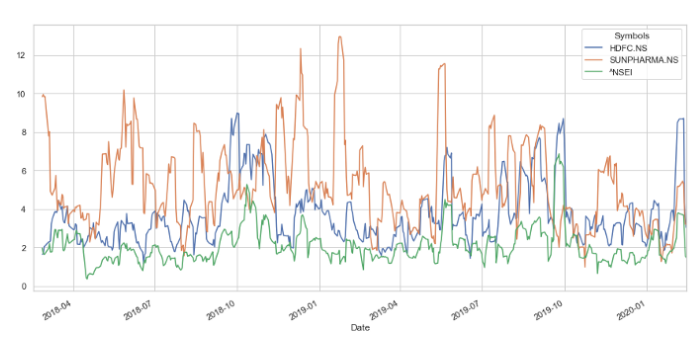

In [34]:
# 주가영향도 점수와, 종목을 매칭하여 날짜별 주가영향도 점수 제공
Image("result_plot_demo.png")

## 끝